In [1]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [12]:
#!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
#!unrar x UCF50.rar -inul -y

In [7]:
all_classes_names = os.listdir('UCF50data1')
print(all_classes_names)

In [5]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
 
# Get Names of all classes in UCF50
all_classes_names = os.listdir('UCF50data1')
 
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 2)
 
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
 
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'UCF50data1/{selected_class_Name}')
 
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'UCF50data1/{selected_class_Name}/{selected_video_file_name}')
     
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
 
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [4]:
image_height, image_width = 64, 64
max_images_per_class = 8000
 
dataset_directory = "UCF50"
classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]
 
model_output_size = len(classes_list)

In [8]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
     
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
 
    # Iterating through Video Frames
    while True:
 
        # Reading a frame from the video file 
        success, frame = video_reader.read() 
 
        # If Video frame was not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
         
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
         
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
     
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # returning the frames list 
    return frames_list

In [9]:
def create_dataset():
 
    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
     
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
         
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
 
        # Iterating through all the files present in the files list
        for file_name in files_list:
 
            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
 
            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)
 
            # Appending the frames to a temporary list.
            temp_features.extend(frames)
         
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))
 
        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
         
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()
 
    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
 
    return features, labels

In [10]:
features, labels = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [11]:
one_hot_encoded_labels = to_categorical(labels)

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# 'features' is your input data (features)
# 'labels' is your corresponding output data (labels)
# test_size=0.2 specifies that 20% of the data will be used for testing
# random_state=42 sets a seed value for reproducibility

# Verify the shapes of the data splits
print("Training set shapes:")
print("Features:", features_train.shape)
print("Labels:", labels_train.shape)
print("Testing set shapes:")
print("Features:", features_test.shape)
print("Labels:", labels_test.shape)

Training set shapes:
Features: (25600, 64, 64, 3)
Labels: (25600,)
Testing set shapes:
Features: (6400, 64, 64, 3)
Labels: (6400,)


In [13]:
#Let's create a function that will construct our model
def create_model():
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))
 
    # Printing the models summary
    model.summary()
 
    return model
 
 # Calling the create_model method
model = create_model()
 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

2023-06-07 13:45:28.824230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
plot_model(model, show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Adding Early Stopping Callback
from keras.utils import to_categorical

# Convert labels to one-hot encoded format
labels_train_encoded = to_categorical(labels_train)

# Define and compile your model

# Start Training




early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start Training
model_training_history = model.fit(x=features_train, y=labels_train_encoded, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
5120/5120 [==============================] - 189s 37ms/step - loss: 0.8737 - accuracy: 0.6495 - val_loss: 0.8387 - val_accuracy: 0.7260
Epoch 2/50
5120/5120 [==============================] - 190s 37ms/step - loss: 0.5280 - accuracy: 0.8087 - val_loss: 0.4247 - val_accuracy: 0.8529
Epoch 3/50
5120/5120 [==============================] - 187s 37ms/step - loss: 0.3929 - accuracy: 0.8641 - val_loss: 0.4798 - val_accuracy: 0.8719
Epoch 4/50
5120/5120 [==============================] - 189s 37ms/step - loss: 0.3250 - accuracy: 0.8865 - val_loss: 0.3580 - val_accuracy: 0.9113
Epoch 5/50
5120/5120 [==============================] - 189s 37ms/step - loss: 0.2862 - accuracy: 0.9013 - val_loss: 0.7317 - val_accuracy: 0.7375
Epoch 6/50
5120/5120 [==============================] - 189s 37ms/step - loss: 0.2467 - accuracy: 0.9166 - val_loss: 0.0938 - val_accuracy: 0.9656
Epoch 7/50
5120/5120 [==============================] - 188s 37ms/step - loss: 0.2343 - accuracy: 0.9224 - val_loss: 0

In [21]:

# Convert labels to one-hot encoded format
labels_test_encoded = to_categorical(labels_test)

# Evaluate the model
model_evaluation_history = model.evaluate(features_test, labels_test_encoded)



#model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 8s 39ms/step - loss: 0.0215 - accuracy: 0.9936


In [23]:
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)


In [24]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
 
  # Constructing a range object which will be used as time 
    epochs = range(len(metric_value_1))
   
  # Plotting the Graph
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
   
  # Adding title to the plot
    plt.title(str(plot_name))
 
  # Adding legend to the plot
    plt.legend()

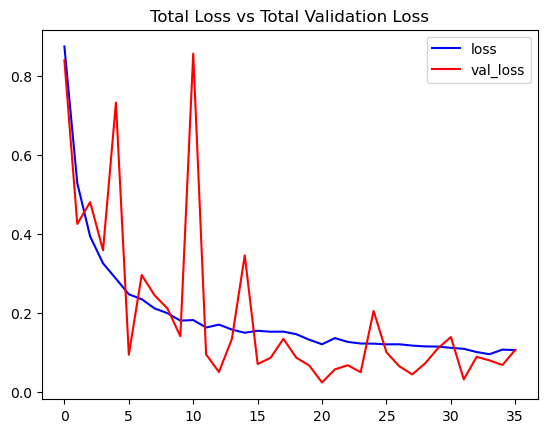

In [25]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

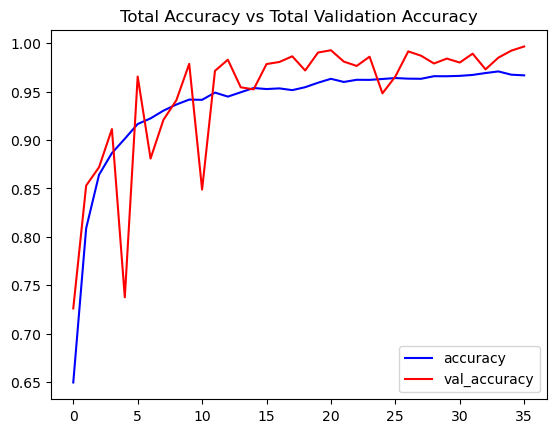

In [26]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')